![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importación librerías
import cudf
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score



ModuleNotFoundError: No module named 'cudf'

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [11]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


<h1>1. Revisión general de las variables</h1>

<h2>Completitud</h2>

Datos completos al 100%

Resultados:
   Columna  Espacios en Blanco  NaN  % Faltantes
0    Price                   0    0          0.0
1     Year                   0    0          0.0
2  Mileage                   0    0          0.0
3    State                   0    0          0.0
4     Make                   0    0          0.0
5    Model                   0    0          0.0


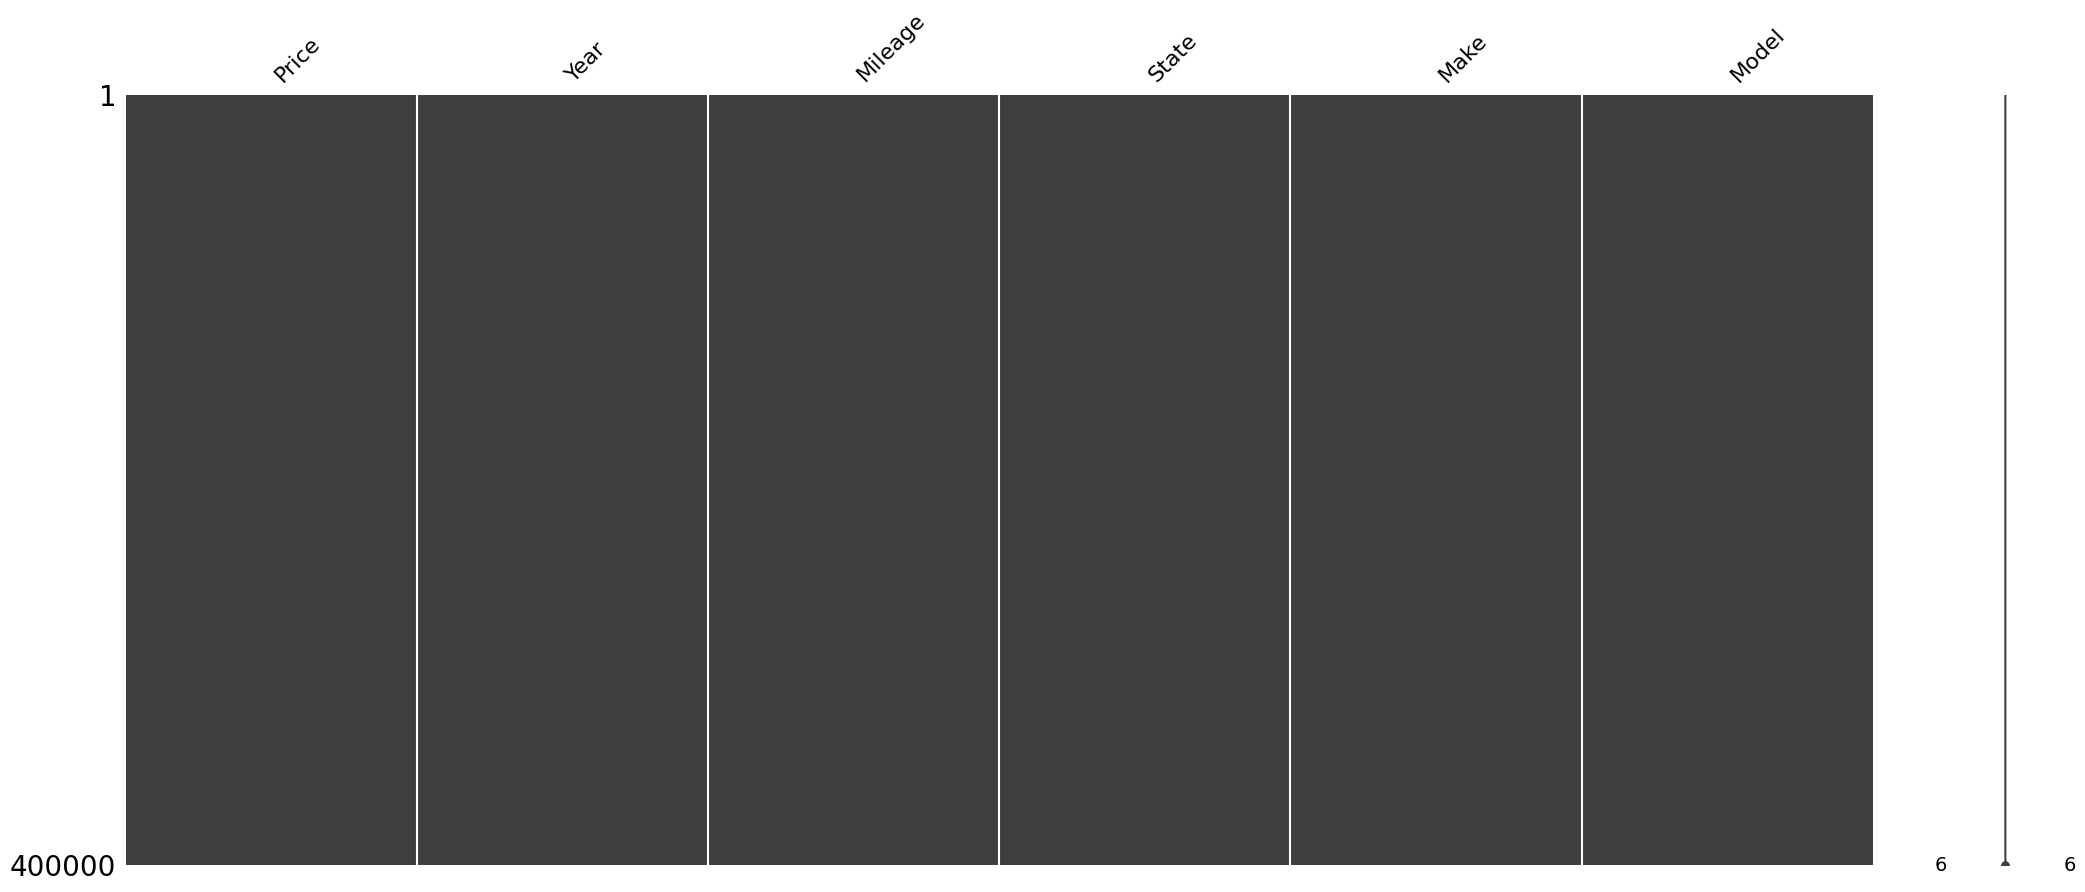

In [7]:
# Completitud de los datos
def analisis_datos(df):
    columnas = []
    espacios_blanco = []
    nan_counts = []
    porcentaje_faltantes = []

    for columna in df.columns:
        espacios_blanco.append(sum(df[columna].apply(lambda x: isinstance(x, str) and x.isspace())))
        nan_counts.append(df[columna].isna().sum())
        porcentaje_faltantes.append((df[columna].isna().sum() + espacios_blanco[-1]) / len(df) * 100)  # Calcula el porcentaje de datos faltantes
        columnas.append(columna)

    resultados_df = pd.DataFrame({
        'Columna': columnas,
        'Espacios en Blanco': espacios_blanco,
        'NaN': nan_counts,
        '% Faltantes': porcentaje_faltantes  # Agrega la columna de porcentaje de datos faltantes
    })

    print("Resultados:")
    print(resultados_df)

    msno.matrix(df)

analisis_datos(dataTraining)

<h1>2. Descripcion de variables</h1>

<h2>Variables Numericas</h2>

In [8]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


<h2>Variables categoricas</h2>

En total se tienen 3 columnas

<table>
  <tr>
    <th>Columnas</th>
    <th># Valores Unicos</th>
  </tr>
  <tr>
    <td>State</td>
    <td>51</td>
  </tr>
  <tr>
    <td>Make</td>
    <td>38</td>
  </tr>
  <tr>
    <td>Model</td>
    <td>525</td>
  </tr>
</table>

Hay un problema y es una alta cantidad de valores unicos.
una propuesta puede ser armar modelos para cada marca ya que tiene un sentido logico

In [9]:
col_numericas=['Year','Mileage']
col_categoricas=['State','Make','Model']
for col in col_categoricas:
  print(f'valores unicos de {col}:{dataTraining[col].unique()}',f'total variables: {len(dataTraining[col].unique())}', '\n')

valores unicos de State:[' FL' ' OH' ' TX' ' CO' ' ME' ' WA' ' CT' ' CA' ' LA' ' NY' ' PA' ' SC'
 ' ND' ' NC' ' GA' ' AZ' ' TN' ' KY' ' NJ' ' UT' ' IA' ' AL' ' NE' ' IL'
 ' OK' ' MD' ' NV' ' WV' ' MI' ' VA' ' WI' ' MA' ' OR' ' IN' ' NM' ' MO'
 ' HI' ' KS' ' AR' ' MN' ' MS' ' MT' ' AK' ' VT' ' SD' ' NH' ' DE' ' ID'
 ' RI' ' WY' ' DC'] total variables: 51 

valores unicos de Make:['Jeep' 'Chevrolet' 'BMW' 'Cadillac' 'Mercedes-Benz' 'Toyota' 'Buick'
 'Dodge' 'Volkswagen' 'GMC' 'Ford' 'Hyundai' 'Mitsubishi' 'Honda' 'Nissan'
 'Mazda' 'Volvo' 'Kia' 'Subaru' 'Chrysler' 'INFINITI' 'Land' 'Porsche'
 'Lexus' 'MINI' 'Lincoln' 'Audi' 'Ram' 'Mercury' 'Tesla' 'FIAT' 'Acura'
 'Scion' 'Pontiac' 'Jaguar' 'Bentley' 'Suzuki' 'Freightliner'] total variables: 38 

valores unicos de Model:['Wrangler' 'Tahoe4WD' 'X5AWD' 'SRXLuxury' '3' 'C-ClassC300' 'CamryL'
 'TacomaPreRunner' 'LaCrosse4dr' 'ChargerSXT' 'CamryLE' 'Jetta'
 'AcadiaFWD' 'EscapeSE' 'SonataLimited' 'Santa' 'Outlander' 'CruzeSedan'
 'Civic' 'Corol

Cantidad de muestras por año 2014: 17.18%
Cantidad de muestras por año 2017: 11.14%
Cantidad de muestras por año 2004: 0.85%
Cantidad de muestras por año 2015: 17.72%
Cantidad de muestras por año 2016: 13.91%
Cantidad de muestras por año 2013: 8.17%
Cantidad de muestras por año 2008: 3.39%
Cantidad de muestras por año 2012: 7.88%
Cantidad de muestras por año 2003: 0.46%
Cantidad de muestras por año 2011: 5.88%
Cantidad de muestras por año 2010: 4.15%
Cantidad de muestras por año 2005: 1.27%
Cantidad de muestras por año 2006: 1.79%
Cantidad de muestras por año 2007: 2.80%
Cantidad de muestras por año 2009: 2.63%
Cantidad de muestras por año 2000: 0.12%
Cantidad de muestras por año 2001: 0.19%
Cantidad de muestras por año 2002: 0.28%
Cantidad de muestras por año 1998: 0.03%
Cantidad de muestras por año 1999: 0.07%
Cantidad de muestras por año 2018: 0.08%
Cantidad de muestras por año 1997: 0.02%


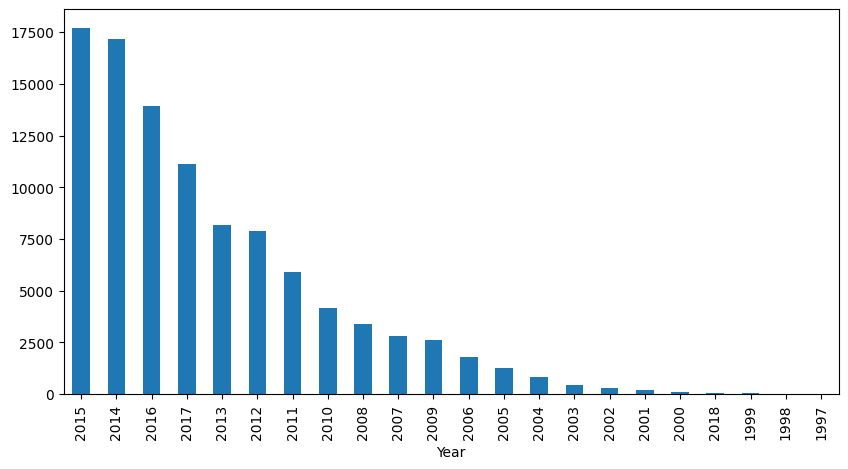

In [34]:
#Cantidad de muestras por Marca
dataTesting['Year'].value_counts().plot(kind='bar',figsize=(10,5))
for val in dataTesting['Year'].unique():
  print(f'Cantidad de muestras por año {val}: {len(dataTesting[dataTesting["Year"]==val])/len(dataTesting)*100:.2f}%')

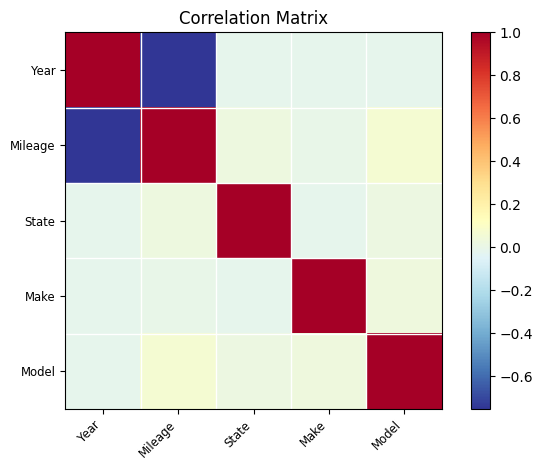

In [45]:
import statsmodels.api as sm
corr = dataTraining_copy.set_index('Price').corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

Debido a la naturaleza de los datos se tienen varias hipoptesis.
- Usar un unico modelo entrenado para predecir para predecir el precio de cada vehiculo basado en el modelo con mejor rendimiento inicial sin hiperparametros definidos
- Usar 1 modelo personalizado por cada item para predecir, segun su marca, modelo, año y kilometraje (si existen todas las variables) para predecir su precio basado en el modelo con mejor rendimiento inicial sin hiperparametros definidos

Cada uno tiene sus retos y transoformaciones
- Agrupacion de variables
- Que modelo usar
- Seleccion de hiperparametros

<h1>3. Modelamiento</h1>

<h2>Procesamiento de variables X y</h2>
se separarán los datos en modelo XTrain y yTrain, ademas se codifican variables categoricas por medio de etiquetas

In [5]:
numeric_cols = ['Price','Year', 'Mileage']
categorical_cols = ['State','MakeModel']

# Define una función para calcular el RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define una función para calcular el coeficiente de determinación (R^2)
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred) 

In [77]:
def encoder(categorical_cols):
  np.random.seed(420)
  label_encoders = {}
  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    dataTraining_copy[col] = label_encoders[col].fit_transform(dataTraining_copy[col])
    dataTesting_copy[col] = label_encoders[col].transform(dataTesting_copy[col])

#Instancio DF Training
dataTraining_copy = dataTraining.copy()
dataTraining_copy['MakeModel']=dataTraining_copy['Make']+dataTraining_copy['Model']
dataTraining_copy=dataTraining_copy.drop(['Make','Model'],axis=1)

#Instancio DF Testing
dataTesting_copy=dataTesting.copy()
dataTesting_copy['MakeModel']=dataTesting_copy['Make']+dataTesting_copy['Model']
dataTesting_copy=dataTesting_copy.drop(['Make','Model','Year'],axis=1)


#Traigo los valores 'Gama' de los datos de entrenamiento
encoder(categorical_cols)


X=dataTraining_copy.drop(['Price','Year'], axis=1)
y=dataTraining_copy[['Price']].values.ravel()

dataTraining_copy[(dataTraining_copy['Mileage'].between(9000,10000))&(dataTraining_copy['MakeModel']==290)]['Price'].describe()

count       80.000000
mean     36117.300000
std       4655.258846
min      27924.000000
25%      32994.750000
50%      34995.000000
75%      39236.750000
max      49997.000000
Name: Price, dtype: float64

<h3>Prediccion con varios modelos basado en un todo general</h3>

En este caso sabemos que Random Forest nos entrega el mejor resultado

Resultado linear: r2=0.23862983412035094 rmse:9383.159244358903
Resultado decision_tree: r2=0.6933643795245459 rmse:5954.745991269062
Resultado XGBoost: r2=0.76206431003551 rmse:5245.374292971184


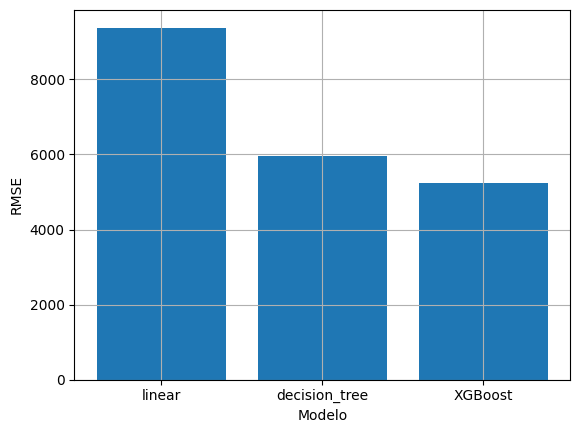

In [70]:
#Primer modelo de regresión

resultados={}

models={
    'linear':LinearRegression(),
    'decision_tree':DecisionTreeRegressor(random_state=1),
    # 'random_forest':RandomForestRegressor(random_state=1),
    # 'gradient_boosting':GradientBoostingRegressor(random_state=1),
    'XGBoost':XGBRegressor(seed=1),
    # 'adaboost+DecisionTree':AdaBoostRegressor(random_state=1,estimator=DecisionTreeRegressor(random_state=1)),
    # 'neural_network':MLPRegressor(random_state=1)
}
for model,function in models.items():
    scores_r2 = cross_val_score(function, X, y, cv=5, scoring=make_scorer(r2))
    scores_rmse = cross_val_score(function, X, y, cv=5, scoring=make_scorer(rmse))
    resultados[model]=scores_rmse.mean()
    print(f'Resultado {model}: r2={scores_r2.mean()} rmse:{scores_rmse.mean()}')

plt.bar(resultados.keys(), resultados.values())
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.grid()
plt.show() 

<h3>Estimador de hiper parametros</h3>

In [71]:
def best_parameters_desissionTree(estimator_range, feature_range, depth_range):
  estim_scores = []
  feat_scores = []
  depth_scores = []
  max_params = {
    'max_estimators': 0,
    'max_estimator_v': 0,
    'max_features': 0,
    'max_features_v': 0,
    'max_depth': 0,
    'max_depth_v': 0
  }

  # Modelo inicial
  clf = RandomForestRegressor(random_state=1)
  # print('Modelo inicial:', pd.Series(cross_val_score(clf, X, y, cv=10)).describe())}
  clf.fit(X, y)
  print('Modelo inicial:', clf.score(X,y))
  
  # Prueba de parámetros
  for max_depth in depth_range:
    for max_features in feature_range:
      for n_estimators in estimator_range:
        print('Entrenando con:', max_depth, max_features,n_estimators)
        clf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=1, n_jobs=-1)
        # cv_score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
        clf.fit(X, y)
        cv_score=clf.score(X,y)

        if cv_score > max_params['max_depth_v']:
          max_params['max_depth_v'] = cv_score
          max_params['max_depth'] = max_depth
          max_params['max_features_v'] = cv_score
          max_params['max_features'] = max_features
          max_params['max_estimator_v'] = cv_score
          max_params['max_estimators'] = n_estimators

        estim_scores.append((n_estimators, cv_score))
        feat_scores.append((max_features, cv_score))
        depth_scores.append((max_depth, cv_score))

  # Print the best params
  print('Mejores parámetros:', max_params)

  return estim_scores, feat_scores, depth_scores, max_params

def best_parameters_XGBoost(estimator_range, depth_range, learning_rate_range, subsample_range, colsample_bytree_range,X,y):
  estim_scores = []
  depth_scores = []
  learning_rate_scores = []
  subsample_scores = []
  colsample_bytree_scores = []

  # Modelo inicial
  clf = XGBRegressor(seed=1)
  scores_r2 = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(r2))
  scores_rmse = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(rmse))
  print('Modelo inicial:', scores_r2.mean(), scores_rmse.mean())
  max_params = {
    'r2_score': 0,
    'rmse':100000,
    'max_estimators': 0,
    'max_depth': 0,
    'max_learning_rate': 0,
    'max_subsample': 0,
    'max_colsample_bytree': 0,
  }
  
  # Prueba de parámetros
  for max_depth in depth_range:
    for n_estimators in estimator_range:
      for learning_rate in learning_rate_range:
        for subsample in subsample_range:
          for colsample_bytree in colsample_bytree_range:
            clf = XGBRegressor(n_estimators=n_estimators, 
              max_depth=max_depth, 
              learning_rate=learning_rate,
              subsample=subsample,
              colsample_bytree=colsample_bytree,
              seed=1)
            scores_r2 = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(r2))
            scores_rmse = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(rmse))
            print(f'Entrenando con: {max_depth,n_estimators,learning_rate,subsample,colsample_bytree}','\n',f'Resultado: R2.{scores_r2.mean()}, RMSE:{scores_rmse.mean()}',end='\r')

            if scores_rmse.mean() < max_params['rmse']:
              max_params['rmse'] = scores_rmse.mean()
              max_params['r2_score'] = scores_r2.mean()
              max_params['max_depth'] = max_depth
              max_params['max_estimators'] = n_estimators
              max_params['max_learning_rate'] = learning_rate
              max_params['max_subsample'] = subsample
              max_params['max_colsample_bytree'] = colsample_bytree

            estim_scores.append((n_estimators, scores_rmse.mean()))
            depth_scores.append((max_depth, scores_rmse.mean()))
            learning_rate_scores.append((learning_rate, scores_rmse.mean()))
            subsample_scores.append((subsample, scores_rmse.mean()))
            colsample_bytree_scores.append((colsample_bytree, scores_rmse.mean()))

  # Print the best params
  print('Mejores parámetros:', max_params)

  return max_params


<h3>Modelo Hiperparametros XGBoost Con el modelo completo</h3>

In [72]:
depth_range = [5,8]
estimator_range = range(2000,3000, 100)
learning_rate_range = [0.01,0.1,1]
subsample_range = [1]
colsample_bytree_range = [0.5]

max_params = best_parameters_XGBoost(estimator_range, depth_range, learning_rate_range, subsample_range, colsample_bytree_range,X,y)

Modelo inicial: 0.76206431003551 5245.374292971184
Entrenando con:  5 2000 0.01 1 0.5 
Entrenando con:  5 2000 0.1 1 0.5 7.670008461752
Entrenando con:  5 2000 1 1 0.5 902.572419661497
Entrenando con:  5 2100 0.01 1 0.5 .600276611543
Entrenando con:  5 2100 0.1 1 0.5 8.183138347464
Entrenando con:  5 2100 1 1 0.5 902.576977158522
Entrenando con:  5 2200 0.01 1 0.5 .600276910748
Entrenando con:  5 2200 0.1 1 0.5 1.313917484948
Entrenando con:  5 2200 1 1 0.5 902.580338872018
Entrenando con:  5 2300 0.01 1 0.5 .600275648629
Entrenando con:  5 2300 0.1 1 0.5 6.661411701209
Entrenando con:  5 2300 1 1 0.5 2.580612922499
Entrenando con:  5 2400 0.01 1 0.5 .600273703645
Entrenando con:  5 2400 0.1 1 0.5 1.856996127166
Entrenando con:  5 2400 1 1 0.5 902.582206280041
Entrenando con:  5 2500 0.01 1 0.5 .600274088774
Entrenando con:  5 2500 0.1 1 0.5 7.688728132777
Entrenando con:  5 2500 1 1 0.5 902.583335013354
Entrenando con:  5 2600 0.01 1 0.5 .6002720304095
Entrenando con:  5 2600 0.1 1 0.

<h3>Prediccion con XGBoost basado en un Marca</h3>

Debido a que hay amplia informacion, se hizo una segregacion de la data a modelar basados en marca, modelo, estado y kilometraje, se entrena un modelo XGBoost y uno a uno se muestran los resultados. Para el ejemplo dado, se ve un resultado 

In [132]:
categorical_cols = ['State','MakeModel']

def encoder_marca(categorical_cols,train,test):
    np.random.seed(420)
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        train[col] = label_encoders[col].fit_transform(train[col])
        test[col] = label_encoders[col].transform(test[col])

modelo={
    'modelo_1':0,
    'modelo_2':0,
    'modelo_3':0,
    'modelo_4':0
}

#____________ORDENA AGRUPA VARIABLES EN DATASET____________
dataTraining_marca = dataTraining.copy()
dataTraining_marca['MakeModel']=dataTraining_marca['Make']+'_'+dataTraining_marca['Model']
dataTraining_marca=dataTraining_marca.drop(['Make','Model'],axis=1)
dataTesting_marca = dataTesting.copy()
dataTesting_marca['MakeModel']=dataTesting_marca['Make']+'_'+dataTesting_marca['Model']
dataTesting_marca=dataTesting_marca.drop(['Make','Model'],axis=1)
dataTesting_marca['Price']=0
dataTesting_marca
encoder_marca(categorical_cols,dataTraining_marca,dataTesting_marca)
pricing_results=[]
resultados={}

#____________Itera para encontrar valores similares____________
for row in dataTesting_marca.iterrows():
#Encuentro datos similares
    similares=dataTraining_marca[
        (dataTraining_marca.MakeModel==row[1].MakeModel)&
        (dataTraining_marca.Year.between(row[1]['Year']-1,row[1]['Year']))&
        (dataTraining_marca.State==row[1].State)&
        (dataTraining_marca.Mileage.between(row[1].Mileage-3000,row[1].Mileage+3000))   
    ].sort_values(by='Mileage')
    if(similares.shape[0]==0):
        similares=dataTraining_marca[
            (dataTraining_marca.MakeModel==row[1].MakeModel)&
            (dataTraining_marca.Year.between(row[1]['Year']-1,row[1]['Year']))&
            (dataTraining_marca.Mileage.between(row[1].Mileage-3000,row[1].Mileage+3000)) 
        ].sort_values(by='Mileage')
        if(similares.shape[0]==0):
            similares=dataTraining_marca[
                (dataTraining_marca.MakeModel==row[1].MakeModel)&
                (dataTraining_marca.Year==row[1].Year)
            ].sort_values(by='Mileage')
            if(similares.shape[0]==0):
                similares=dataTraining_marca[(dataTraining_marca.MakeModel==row[1].MakeModel)].sort_values(by='Mileage')
                modelo['modelo_4']+=1
            else:    
                modelo['modelo_3']+=1
        else:
            modelo['modelo_2']+=1
    else:
        modelo['modelo_1']+=1

#____________Normaliza datos atipicos por medio de Media acotada si encuentra mas de 1 valor____________

#Modelo
    X_similares=similares.drop(['Price'], axis=1)
    y_similares=similares[['Price']].values.ravel()


#MODELO XGBOOST
    model = XGBRegressor(n_estimators=2000, 
    max_depth=5, 
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.5,
    seed=1
)
    model.fit(X_similares, y_similares)


#Predigo con modelo
    pred=model.predict([row[1].drop(['Price'])])
    pricing_results.append(np.round(pred[0]).astype(int))
    print(f'trabajando: {round((row[0]/100000)*100,2)}%', end='\r')
#Genero documento

dataTesting_marca['Price']=pricing_results
y_pred = pd.DataFrame(dataTesting_marca, index=dataTesting_marca.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
print(modelo)
print('>_> (100% papa)')


{'modelo_1': 64574, 'modelo_2': 32015, 'modelo_3': 3335, 'modelo_4': 76}
>_> (100% papa)


<h3>playground con datos de dataTraining</h3>

In [105]:


categorical_cols = ['State','MakeModel']

def encoder_marca(categorical_cols,train):
    np.random.seed(1)
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        train[col] = label_encoders[col].fit_transform(train[col])

def XGBoost_marca():
    modelo={
        'modelo_1':0,
        'modelo_2':0,
        'modelo_3':0,
        'modelo_4':0
    }

    #____________ORDENA AGRUPA VARIABLES EN DATASET____________
    dataTraining_marca = dataTraining.copy()
    dataTraining_marca['MakeModel']=dataTraining_marca['Make']+'_'+dataTraining_marca['Model']
    dataTraining_marca=dataTraining_marca.drop(['Make','Model'],axis=1)
    encoder_marca(categorical_cols,dataTraining_marca)
    pricing_results=[]
    resultados={}

    dataTesting_marca = dataTraining_marca.sample(n=100000,random_state=42)
    dataTraining_marca = dataTraining_marca.drop(dataTesting_marca.index)


    for row in dataTesting_marca.iterrows():
        similares=dataTraining_marca[
            (dataTraining_marca.MakeModel==row[1].MakeModel)&
            (dataTraining_marca.State==row[1].State)&
            (dataTraining_marca.Year.between(row[1].Year-2,row[1].Year+2))&
            (dataTraining_marca.Mileage.between(row[1].Mileage-3000,row[1].Mileage+3000))   
        ].sort_values(by='Mileage')
        if(similares.shape[0]==0):
            similares=dataTraining_marca[
                (dataTraining_marca.MakeModel==row[1].MakeModel)&
                (dataTraining_marca.Mileage.between(row[1].Mileage,row[1].Mileage+8000))  
            ].sort_values(by='Mileage')
            modelo_utilizado='modelo_2'
        else:
            modelo_utilizado='modelo_1'
        modelo[modelo_utilizado]+=1


    #Modelo
        X_similares=similares.drop(['Price'], axis=1)
        y_similares=similares[['Price']].values.ravel()

        #MODELO XGBOOST
        model = XGBRegressor(n_estimators=2000, 
        max_depth=5, 
        learning_rate=0.1,
        subsample=1,
        colsample_bytree=0.5,
        seed=1
    )
        model.fit(X_similares, y_similares)
    #Predigo con modelo
        pred=model.predict([row[1].drop(['Price'])])
        pricing_results.append(np.round(pred[0]).astype(int))
        print(f'trabajando: {round((row[0]/100000)*100,2)}%', end='\r')
        print(f'indice {row[0]} Diferencia Cuartiles:{((Q1+Q3)/2)-row[1].Price}, Diferencia de prediccion:{np.round(pred[0]).astype(int)-row[1].Price}, modelo utilizado:{modelo_utilizado}')

# XGBoost_marca()


#_________EVALUADOR_________




# dataTesting_marca['Price_modelo']=pricing_results

<h3>Calibrador de playground</h3>

In [131]:
categorical_cols = ['State','MakeModel']

def encoder_marca(categorical_cols,train):
    np.random.seed(420)
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        train[col] = label_encoders[col].fit_transform(train[col])


df_calibrador=dataTraining.copy()
df_calibrador['MakeModel']=df_calibrador['Make']+'_'+df_calibrador['Model']
df_calibrador=df_calibrador.drop(['Make','Model'],axis=1)
encoder_marca(categorical_cols,df_calibrador)
sample=df_calibrador.iloc[20731]
print(sample)

query=df_calibrador[
    (df_calibrador['MakeModel']==sample['MakeModel'])&
    (df_calibrador['Mileage'].between(sample['Mileage']-3000,sample['Mileage']+3000))&
    (df_calibrador['Year'].between(sample['Year']-1,sample['Year']))&
    (df_calibrador['State']==sample['State'])
].sort_values(by='Mileage')

X_similares=query.drop(['Price'], axis=1)
y_similares=query[['Price']].values.ravel()


model = XGBRegressor(n_estimators=2000, 
    max_depth=5, 
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.5,
    seed=1
)
model.fit(X_similares, y_similares)
pred=model.predict([sample.drop(['Price'])])

print(f'Mean:',query['Price'].mean())
print(f'Prediccion:',pred[0].astype(int))
query,query.describe()

Price        16999
Year          2010
Mileage      99603
State           47
MakeModel      211
Name: 20731, dtype: int64
Mean: 20987.75
Prediccion: 16999


(       Price  Year  Mileage  State  MakeModel
 87550  21990  2009    96948     47        211
 18838  25995  2010    98350     47        211
 12756  18967  2009    98463     47        211
 20731  16999  2010    99603     47        211,
               Price        Year       Mileage  State  MakeModel
 count      4.000000     4.00000      4.000000    4.0        4.0
 mean   20987.750000  2009.50000  98341.000000   47.0      211.0
 std     3918.784452     0.57735   1087.513678    0.0        0.0
 min    16999.000000  2009.00000  96948.000000   47.0      211.0
 25%    18475.000000  2009.00000  97999.500000   47.0      211.0
 50%    20478.500000  2009.50000  98406.500000   47.0      211.0
 75%    22991.250000  2010.00000  98748.000000   47.0      211.0
 max    25995.000000  2010.00000  99603.000000   47.0      211.0)

<h3>Encontrando los mejores hiperparametros</h3>

In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

              Price
ID                 
0      33090.508914
1      76303.572981
2      59899.545636
3      49899.386315
4      16701.398033
...             ...
99995  64422.862300
99996  63443.967139
99997  55584.005547
99998  42458.543350
99999  34243.136396

[100000 rows x 1 columns]


<h3>Prediccion con XGBoost basado en un todo el modelo</h3>

In [101]:
# Guardar predicciones en formato exigido en la competencia de kaggle

clf = XGBRegressor(n_estimators=2000, 
  max_depth=5, 
  learning_rate=0.1,
  subsample=1,
  colsample_bytree=0.5,
  seed=1
)
clf.fit(X,y)
pred=clf.predict(dataTesting_copy)
valor_final=np.round(pred).astype(int)
y_pred = pd.DataFrame(valor_final, index=dataTesting_copy.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()


NameError: name 'X' is not defined